Performance of NN 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive 


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
cd /gdrive/My\ Drive/nn 

/gdrive/My Drive/nn


In [ ]:
%tensorflow_version 1.x
import argparse
import os
import pickle
import sys
import glob

import numpy as np

np.random.seed(7)  # for reproducibility

import tensorflow as tf
tf.random.set_random_seed(5005)

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc 


from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.pooling import MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.python.keras.backend as K

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn')
mpl.use('Agg')
%matplotlib inline

import utils
sys.path.append(".")
from utils import *

from tensorflow.python.keras.backend import set_session
from scipy.stats import pearsonr

CLASS_PARTIAL_LOSS = 0
CLASS_COMPLETELY_LOSS = 1 

In [ ]:
def draw_confusion_matrix(y_test, y_pred):
  """
  Draw a confusion matrix based on the predictions and true labels
  :param y_test: np.array of the true labels
  :param y_pred: np.array of the predictions labels
  """
  cm = confusion_matrix(y_test, y_pred_keras)
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['Negative','Positive']
  plt.title('Confusion matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
  plt.show()

def get_prediction_based_on_wcgw(x_test):
  """
  Get a prediction of dataset using the wcgw rules
  """
  pred = []
  for i  in range(len(x_test)):
    mini_seq = x_test[i][73:77]
    if mini_seq in ["ACGA", "ACGT", "TCGA", "TCGT"]:
      pred.append(CLASS_COMPLETELY_LOSS)
    else:
      pred.append(CLASS_PARTIAL_LOSS)

  return pred

def get_prediction_based_on_wcgw_cpgs1(x_test):
  """
  Get a prediction of dataset using the wcgw rules
  """
  pred = []
  for i  in range(len(x_test)):
    if x_test[i].count("CG") >1:
      pred.append(CLASS_PARTIAL_LOSS)
      continue

    mini_seq = x_test[i][73:77]
    if mini_seq in ["ACGA", "ACGT", "TCGA", "TCGT"]:
      pred.append(CLASS_COMPLETELY_LOSS)
    else:
      pred.append(CLASS_PARTIAL_LOSS)

  return pred

def get_prediction_based_on_flank(x_train_seq, y_train, x_test, flank_size=1):
  """
  Get a prediction of dataset using dictionary of flank
  :param x_train_seq: The train set for the dictionary learning phase 
  :param y_train: The train labels for the dictionary learning phase
  :param x_test: The test dataset to predict on
  :param flank_size: The amount of flank neucliotides to use for prediciton
  :return: The prediction for the x_test
  """
  one_label_factor = np.sum(y_train == 0) / y_train.shape[0]
  zero_label_factor = np.sum(y_train==1) / y_train.shape[0]
  seqs_dict = {}
  for i  in range(len(x_train_seq)):
    seq = x_train_seq[i]
    mini_seq = seq[74-flank_size:76+flank_size]

    if mini_seq not in seqs_dict:
      seqs_dict[mini_seq] = 0

    if y_train[i] == 1:
      seqs_dict[mini_seq] += one_label_factor
    else:
      seqs_dict[mini_seq] -=zero_label_factor

  pred = []
  for i in range(len(x_test)):
    seq = x_test[i]
    mini_seq = seq[74-flank_size:76+flank_size]
    if mini_seq not in seqs_dict:
      pred.append(1)
      continue
    
    majority_vote = seqs_dict[mini_seq]
    if majority_vote >0:
      pred.append(1)
    else:
      pred.append(0)

  return pred 

In [ ]:
def get_nn_performace(data_path, bian_models_folder, zhou_models_folder, title, other_data):
  """
  Print a ROC curve of the NN compare to other models
  :param data_path: Path for the data
  :param bian_models_folder: Path for the bian models
  :parma zhou_models_folder: Path for the zhou models
  :param title: Title for the ROC curve 
  :param other_data: Other dataset we need to check our test sequences doesn't contain to prevent testing on trained sequences
  """
  print("Loading data")
  _,_,_,_, x_test_seq, y_test, x_train_seq, _ = load_train_validate_test_data(data_path, 150, False, kfold=1)
  _, _,_,_,_,_, other_train_seq,_  = load_train_validate_test_data(other_data, 150, False, kfold=1)
  
  print("Removing bad sequences")
  trained_seq = vecs2dna(x_train_seq)
  other_seq_l = vecs2dna(other_train_seq)
  test_seq = vecs2dna(x_test_seq)
  
  shared =set(trained_seq + other_seq_l) & set(test_seq)
  good_indexes = [i for i in range(len(test_seq)) if test_seq[i] not in shared]
  print("Keeping %s of data" % (len(good_indexes) / len(test_seq)))
  x_test_seq, y_test = x_test_seq[good_indexes], y_test[good_indexes]
  test_seq = np.array(test_seq)[good_indexes]

  print("Load and predict on models")
  # Load the models 
  models_paths = glob.glob(os.path.join(bian_models_folder, "*"))
  bian_models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]

  models_paths = glob.glob(os.path.join(zhou_models_folder, "*"))
  zhou_models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]

  # Get predictions using different models 
  bian_y_pred_keras  = predict(bian_models, x_test_seq).ravel()
  zhou_y_pred_keras  = predict(zhou_models, x_test_seq).ravel()
  
  # Get predictions based on flanking to compare to the nn
  print("Predict on basic models")
  wcgw_pred = get_prediction_based_on_wcgw_cpgs1(test_seq)

  precision_wcgw, recall_wcgw, _ = precision_recall_curve(y_test,wcgw_pred)
  average_precision_wcgw = average_precision_score(y_test,wcgw_pred)
  pr_auc_wcgw= auc(recall_wcgw,precision_wcgw)
 
  # Compute ROC curve and AUC 
  print("Create roc curves")
  fpr_keras_sc, tpr_keras_sc, thresholds_keras_sc = roc_curve(y_test, bian_y_pred_keras)
  auc_keras_sc = auc(fpr_keras_sc, tpr_keras_sc)

  precision_sc, recall_sc, _ = precision_recall_curve(y_test,bian_y_pred_keras)
  average_precision_sc = average_precision_score(y_test,bian_y_pred_keras)
  pr_auc_sc= auc(recall_sc,precision_sc)

  fpr_keras_zhou, tpr_keras_zhou, thresholds_keras_zhou = roc_curve(y_test, zhou_y_pred_keras)
  auc_keras_zhou = auc(fpr_keras_zhou, tpr_keras_zhou)
  precision_zhou, recall_zhou, _ = precision_recall_curve(y_test,zhou_y_pred_keras)
  average_precision_zhou = average_precision_score(y_test,zhou_y_pred_keras)
  pr_auc_zhou= auc(recall_zhou,precision_zhou)

  fpr_wcgw,tpr_wcgw, thresholds_wcgw = roc_curve(y_test, wcgw_pred)
  auc_wcgw = auc(fpr_wcgw, tpr_wcgw)

  fig1 = plt.figure(1, dpi=200)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras_sc, tpr_keras_sc, label='Bian NN (area = {:.3f})'.format(auc_keras_sc))
  plt.plot(fpr_keras_zhou, tpr_keras_zhou, label='Zhou NN (area = {:.3f})'.format(auc_keras_zhou))
  # plt.plot(fpr_3, tpr_2, label='3-flank (area = {:.3f})'.format(auc_3))
  # plt.plot(fpr_2, tpr_2, label='2-flank (area = {:.3f})'.format(auc_2))
  # plt.plot(fpr_1, tpr_1, label='1-flank (area = {:.3f})'.format(auc_1))
  plt.plot(fpr_wcgw,tpr_wcgw, label='CPG1-WCGW (area = {:.3f})'.format(auc_wcgw))

  plt.xlabel('False positive rate',fontsize="xx-large")
  plt.ylabel('True positive rate',fontsize="xx-large")
  plt.title('ROC curve %s' %title, fontsize="xx-large")
  plt.legend(fontsize="xx-large",  bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.xticks(fontsize="xx-large")
  plt.yticks(fontsize="xx-large")
  plt.show()
  
  fig2 = plt.figure(1, dpi=200)
  plt.plot(recall_sc, precision_sc, lw=2, label="Bian NN (AP={0:0.2f})".format(average_precision_sc))
  plt.plot(recall_zhou, precision_zhou, lw=2, label="Zhou NN (AP={0:0.2f})".format(average_precision_zhou))
  plt.plot(recall_wcgw, precision_wcgw, lw=2, label="CPG1-WCGW (AP={0:0.2f})".format(average_precision_wcgw))

  plt.xlabel("Recall",fontsize="xx-large")
  plt.ylabel("Precision",fontsize="xx-large")
  plt.title("Precision-Recall curve %s" %title, fontsize="xx-large")
  plt.legend(fontsize="xx-large",  bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.xticks(fontsize="xx-large")
  plt.yticks(fontsize="xx-large")
  plt.show()

  return fig1,fig2

In [ ]:
def get_nn_performace_against_flank(data_path, models_path, title):
  """
  Print a ROC curve of the NN compare to other models
  :param data_path: Path for the data
  :param models path: Path for the models
  :param title: Title for the ROC curve 
  """
  print("Loading data")
  _,_,_,_, x_test_seq, y_test, x_train_seq, y_train = load_train_validate_test_data(data_path, 150, False, kfold=1)
  
  print("Convert to seq info")
  test_seq = vecs2dna(x_test_seq)
  trained_seq = vecs2dna(x_train_seq)

  print("Load and predict on models")
  # Load the models 
  models_paths = glob.glob(os.path.join(models_path, "*"))
  models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]

  # Get predictions using different models 
  y_pred_keras  = predict(models, x_test_seq).ravel()
  
  # Get predictions based on flanking to compare to the nn
  print("Predict on basic models")
  # wcgw_pred = get_prediction_based_on_wcgw(test_seq)

  flank1_pred = get_prediction_based_on_flank(trained_seq, y_train, test_seq, flank_size=1)
  flank2_pred = get_prediction_based_on_flank(trained_seq, y_train, test_seq, flank_size=2)
  flank3_pred = get_prediction_based_on_flank(trained_seq, y_train, test_seq, flank_size=3)

  print("Create roc curves")
  # Compute ROC curve and AUC 
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
  auc_keras = auc(fpr_keras, tpr_keras)


  fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, flank1_pred)
  auc_1 = auc(fpr_1, tpr_1)

  fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, flank2_pred)
  auc_2 = auc(fpr_2, tpr_2)

  fpr_3, tpr_3, thresholds_3 = roc_curve(y_test, flank3_pred)
  auc_3 = auc(fpr_3, tpr_3)

  fig1 = plt.figure(1, dpi=200)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='NN (area = {:.3f})'.format(auc_keras))
  plt.plot(fpr_3, tpr_2, label='3-flank (area = {:.3f})'.format(auc_3))
  plt.plot(fpr_2, tpr_2, label='2-flank (area = {:.3f})'.format(auc_2))
  plt.plot(fpr_1, tpr_1, label='1-flank (area = {:.3f})'.format(auc_1))

  plt.xlabel('False positive rate',fontsize="xx-large")
  plt.ylabel('True positive rate',fontsize="xx-large")
  plt.title('ROC curve %s' %title,fontsize="xx-large")
  plt.legend(loc='best',fontsize="xx-large")
  plt.xticks(fontsize="xx-large")
  plt.yticks(fontsize="xx-large")
  plt.show()

  return fig1 

Run the performances

In [ ]:
bian_data = r"dataset/bian_crc01_train_test.pkl"
zhou_data = r"dataset/zhou_train_test.pkl"

models_folder_zhou ="./models/zhou"
models_folder_bian = "./models/bian"

Loading data
Removing bad sequences
Keeping 0.9997743812747699 of data
Load and predict on models
Predict on basic models
Create roc curves


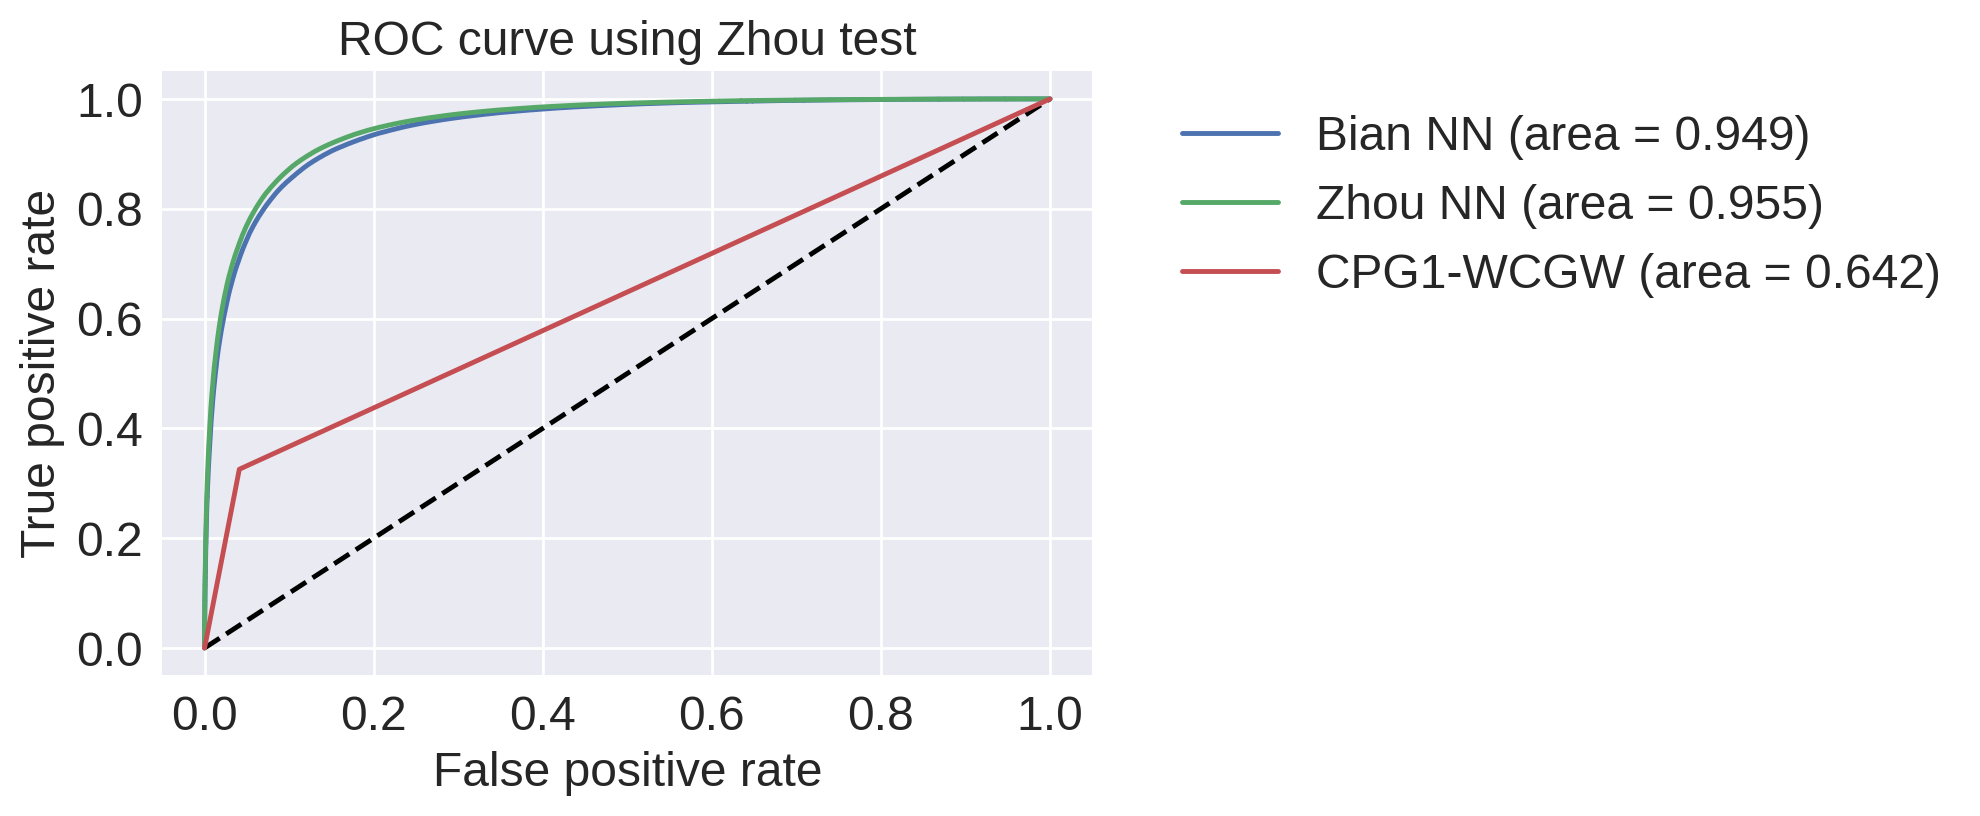

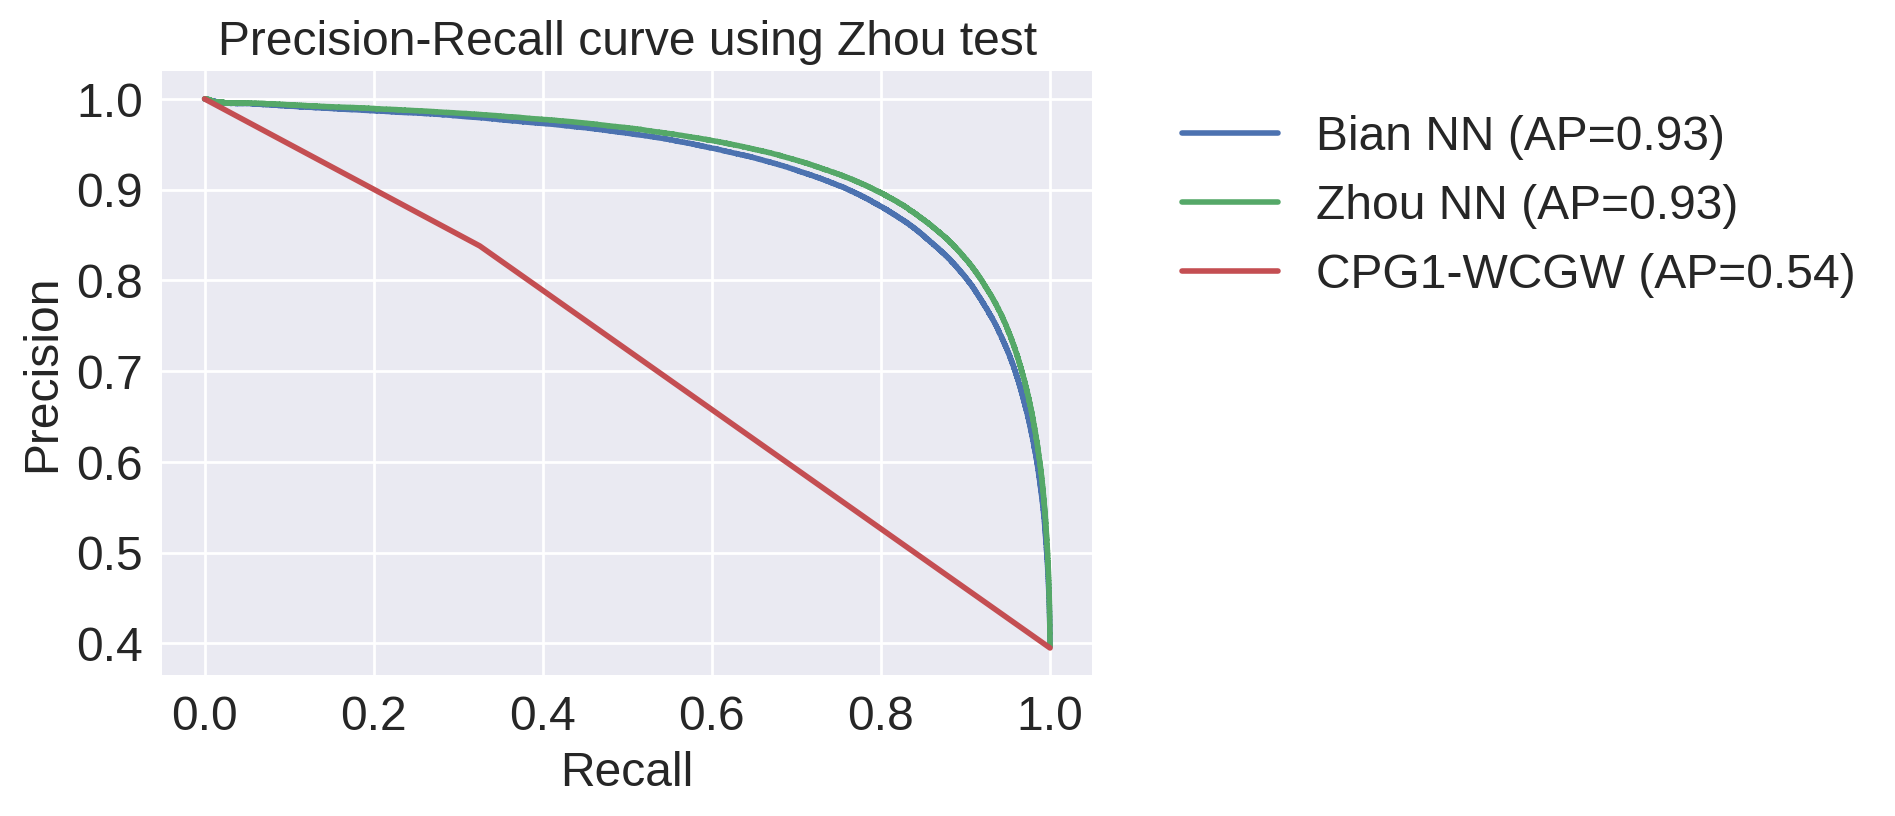

In [ ]:
# Get roc curve of bulk dataset
fig1,fig2 = get_nn_performace(data_path=zhou_data, bian_models_folder=models_folder_bian, zhou_models_folder=models_folder_zhou, title="using Zhou test", other_data=bian_data)

In [ ]:
fig1.savefig("2_d_left.pdf", bbox_inches='tight')
fig2.savefig("sup2_a_left.pdf", bbox_inches='tight')

Loading data
Removing bad sequences
Keeping 0.9990358133296421 of data
Load and predict on models
Predict on basic models
Create roc curves


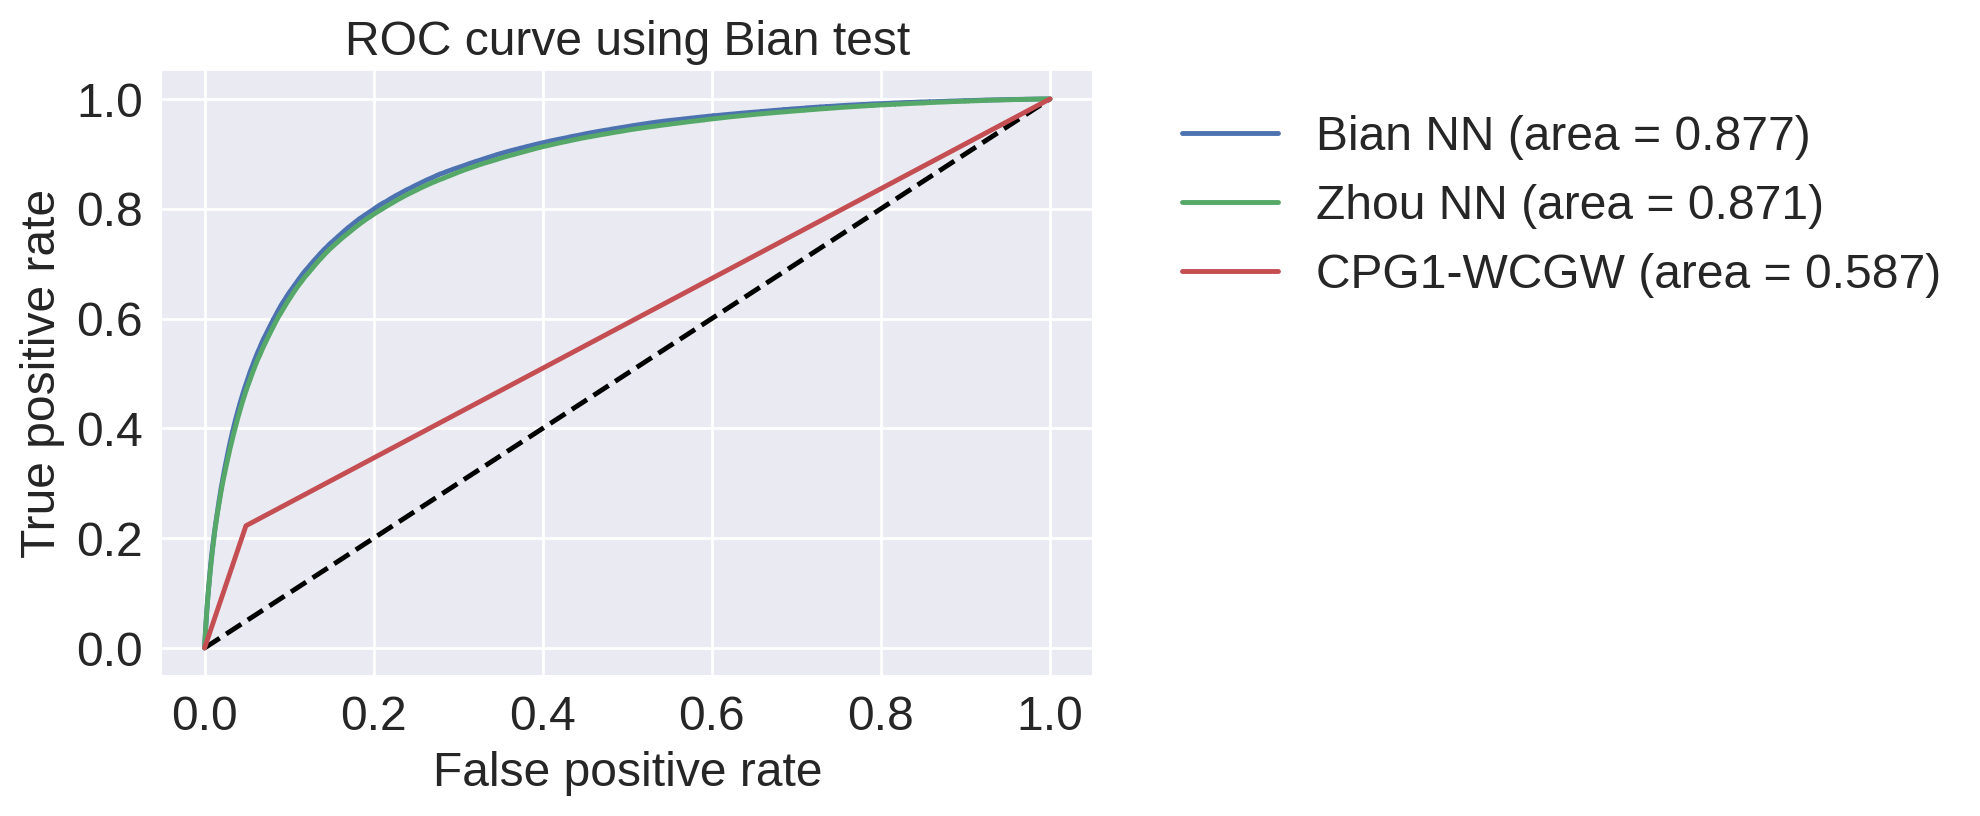

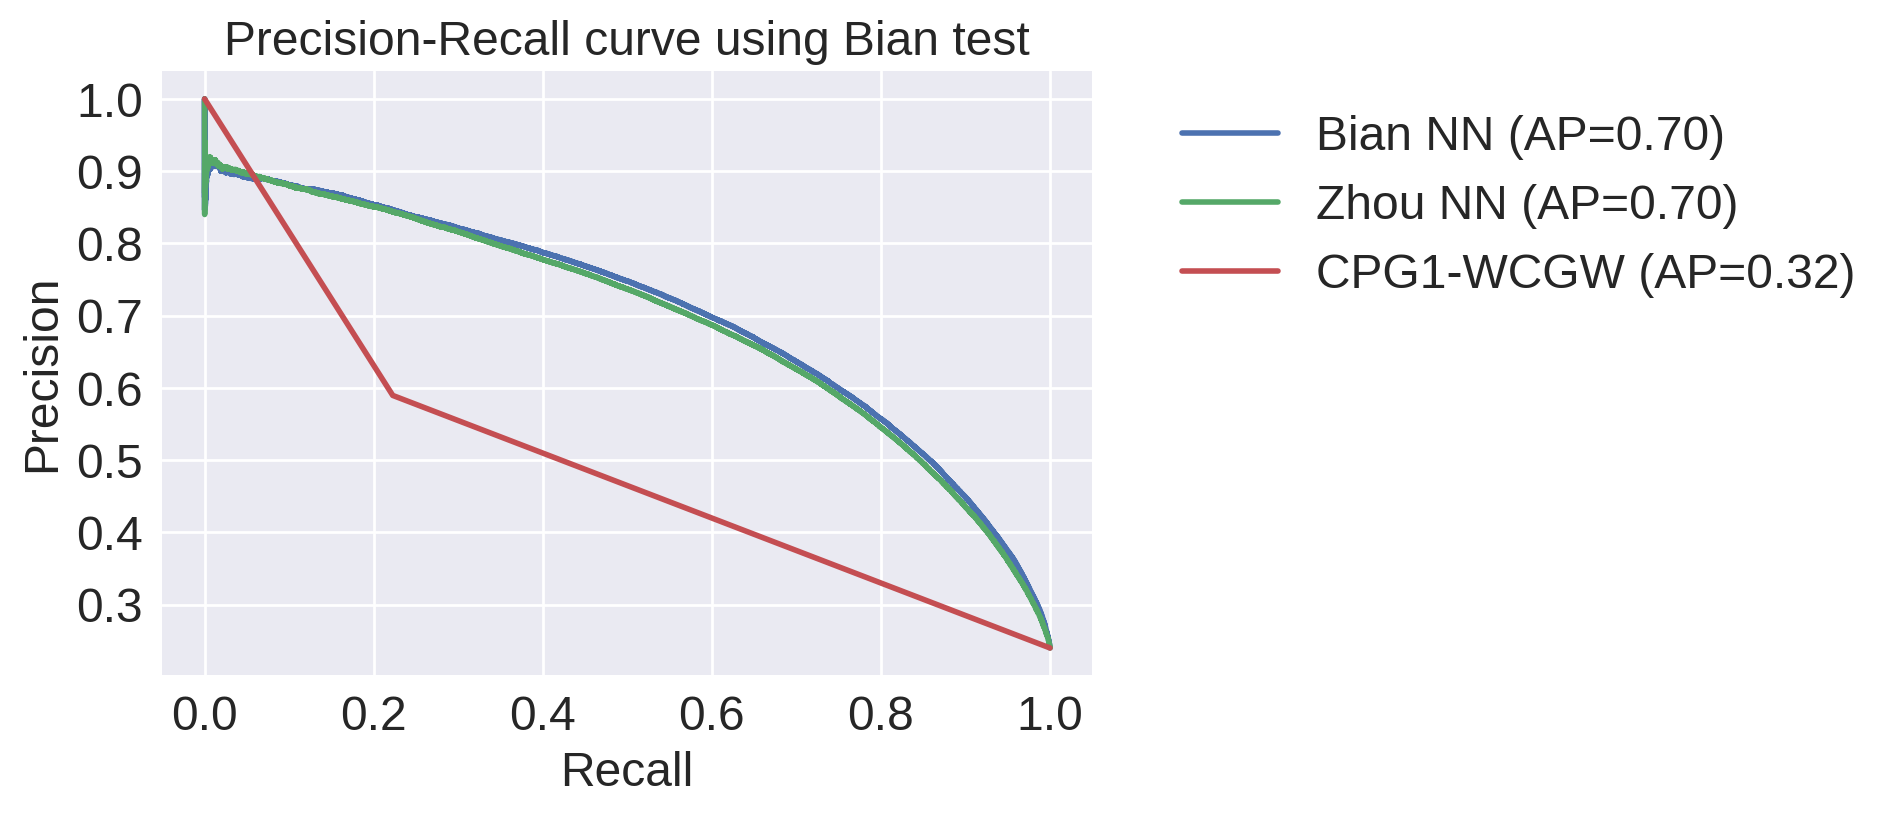

In [ ]:
fig1,fig2 = get_nn_performace(other_data=zhou_data, bian_models_folder=models_folder_bian, zhou_models_folder=models_folder_zhou, title="using Bian test", data_path=bian_data)

In [ ]:
fig1.savefig("2_d_right.pdf", bbox_inches='tight')
fig2.savefig("sup2_a_right.pdf", bbox_inches='tight')

# Compare shared sequences predictions

In [ ]:
zhou_models_folder="./models/zhou"
bian_models_folder="./models/bian"

bian_data = r"dataset/bian_crc01_train_test.pkl"
zhou_all_data = r"dataset/zhou_train_test.pkl"

In [ ]:
 print("Load data")
_,_,_,_, bian_test_seq, bian_test_y,_,_ = load_train_validate_test_data(bian_data, 150, True, kfold=1)
models_paths = glob.glob(os.path.join(bian_models_folder, "*"))
bian_models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]
bian_pred  = predict(bian_models, bian_test_seq).ravel()

bian_seq = vecs2dna(bian_test_seq)
bian_pred_coupled = [(bian_pred[i],bian_test_y[i]) for i in range(bian_pred.shape[0])]
bian_dict = dict(zip(bian_seq,bian_pred_coupled))

_,_,_,_, zhou_test_seq, zhou_test_y,_,_ = load_train_validate_test_data(zhou_all_data, 150, True, kfold=1)
models_paths = glob.glob(os.path.join(zhou_models_folder, "*"))
zhou_models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]
zhou_pred  = predict(zhou_models, zhou_test_seq).ravel()
zhou_seq = vecs2dna(zhou_test_seq)

bian_pred_coupled = [(zhou_pred[i],zhou_test_y[i]) for i in range(zhou_pred.shape[0])]
zhou_dict = dict(zip(zhou_seq,bian_pred_coupled))

print("Removed shared sequences")
# Get shared sequences 

shared = set(zhou_seq) & set(bian_seq)
predicted_shared = []
for seq in shared:
  predicted_shared.append((zhou_dict[seq], bian_dict[seq]))

# Calculate pearson correlation
pc = [(i[0][0],i[1][0]) for i in predicted_shared]
corr, _ = pearsonr([i[0] for i in pc], [i[1] for i in pc])
print("Pearson correlation value is: %s" %corr)


Load data
Removed shared sequences
Pearson correlation value is: 0.9685915907294387


In [ ]:

print("Calculate values for graph")
zhou_ind = 0
bian_index = 1
pred_index=0
label_index = 1
hypo_resistant = 0
hypo_prone = 1

# Plot two graphs
zhou_resist_resist = [predicted_shared[i][zhou_ind][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][zhou_ind][label_index] == hypo_resistant and predicted_shared[i][bian_index][label_index] == hypo_resistant)]
zhou_resist_prone = [predicted_shared[i][zhou_ind][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][zhou_ind][label_index] == hypo_resistant and predicted_shared[i][bian_index][label_index] == hypo_prone)]
zhou_prone_resist = [predicted_shared[i][zhou_ind][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][zhou_ind][label_index] == hypo_prone and predicted_shared[i][bian_index][label_index] == hypo_resistant)]
zhou_prone_prone = [predicted_shared[i][zhou_ind][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][zhou_ind][label_index] == hypo_prone and predicted_shared[i][bian_index][label_index] == hypo_prone)]

bian_resist_resist= [predicted_shared[i][bian_index][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][zhou_ind][label_index] == hypo_resistant and predicted_shared[i][bian_index][label_index] == hypo_resistant)]
bian_resist_prone = [predicted_shared[i][bian_index][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][zhou_ind][label_index] == hypo_resistant and predicted_shared[i][bian_index][label_index] == hypo_prone)]
bian_prone_resist = [predicted_shared[i][bian_index][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][zhou_ind][label_index] == hypo_prone and predicted_shared[i][bian_index][label_index] == hypo_resistant)]
bian_prone_prone = [predicted_shared[i][bian_index][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][zhou_ind][label_index] == hypo_prone and predicted_shared[i][bian_index][label_index] == hypo_prone)]


Calculate values for graph


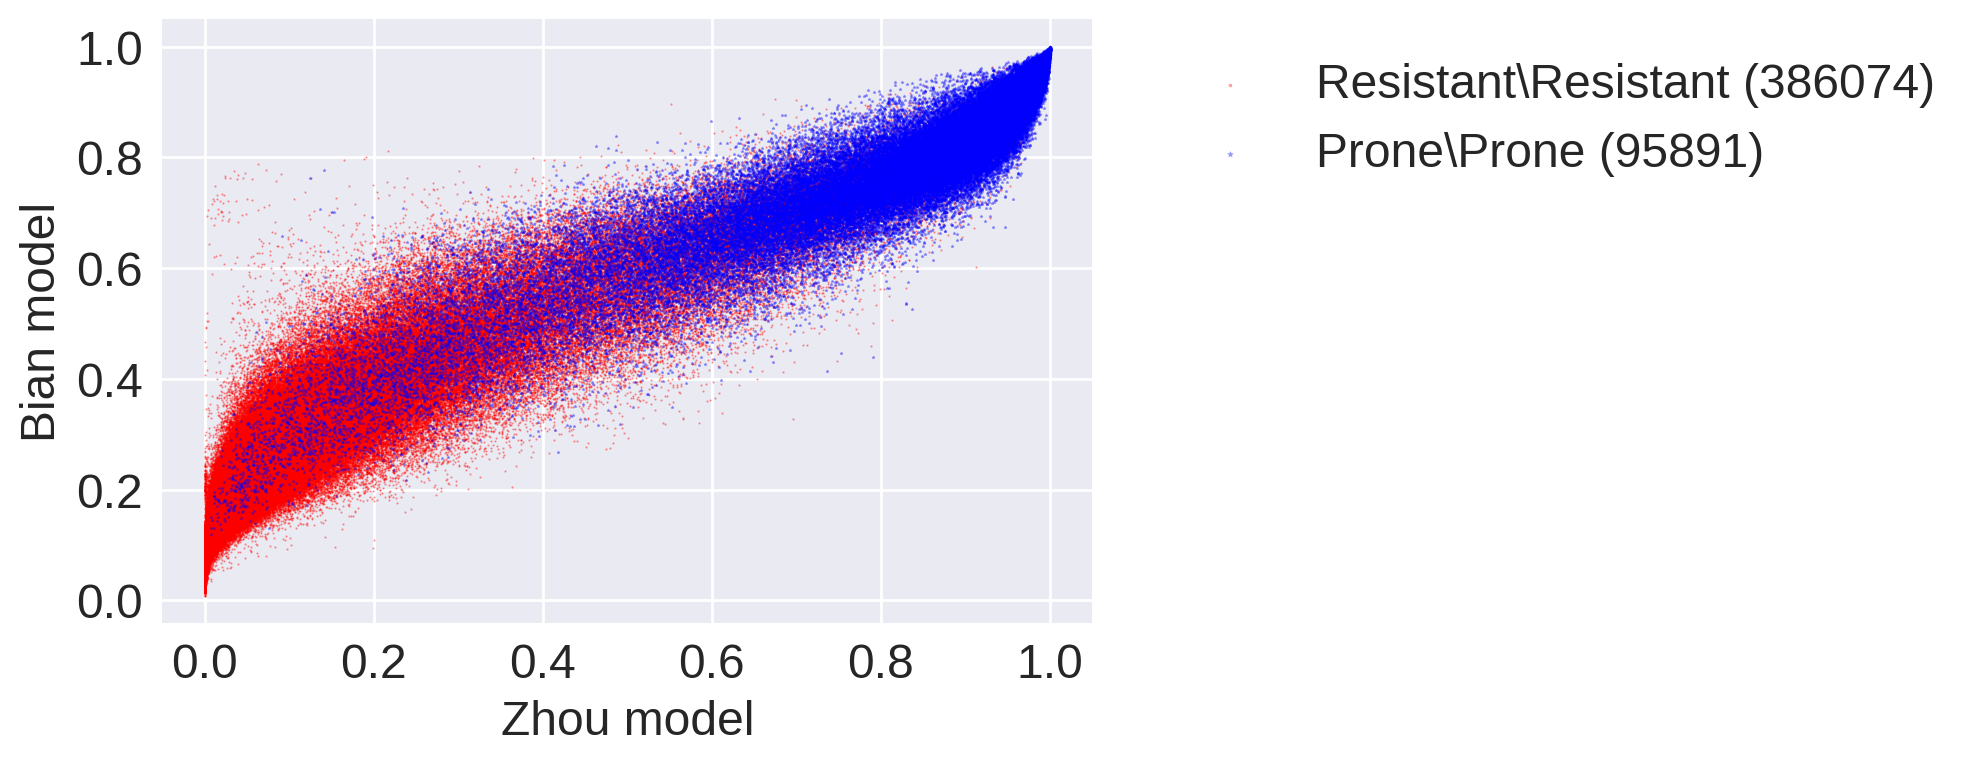

In [ ]:
fig = plt.figure(1, dpi=200)
plt.scatter(zhou_resist_resist, bian_resist_resist, marker=".",label="Resistant\Resistant (%s)" %len(zhou_resist_resist), c="red", alpha=0.3,s=1)
plt.scatter(zhou_prone_prone, bian_prone_prone, marker="*",label="Prone\Prone (%s)" % len(bian_prone_prone), c="blue",alpha=0.3,s=1)


plt.xlabel("Zhou model", fontsize="xx-large")
plt.ylabel("Bian model", fontsize= "xx-large")
# plt.title("Prediction scores on all test sequences with same label", fontsize="xx-large")
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale =2, fontsize="xx-large")

fig.savefig("2_e.pdf", bbox_inches='tight')


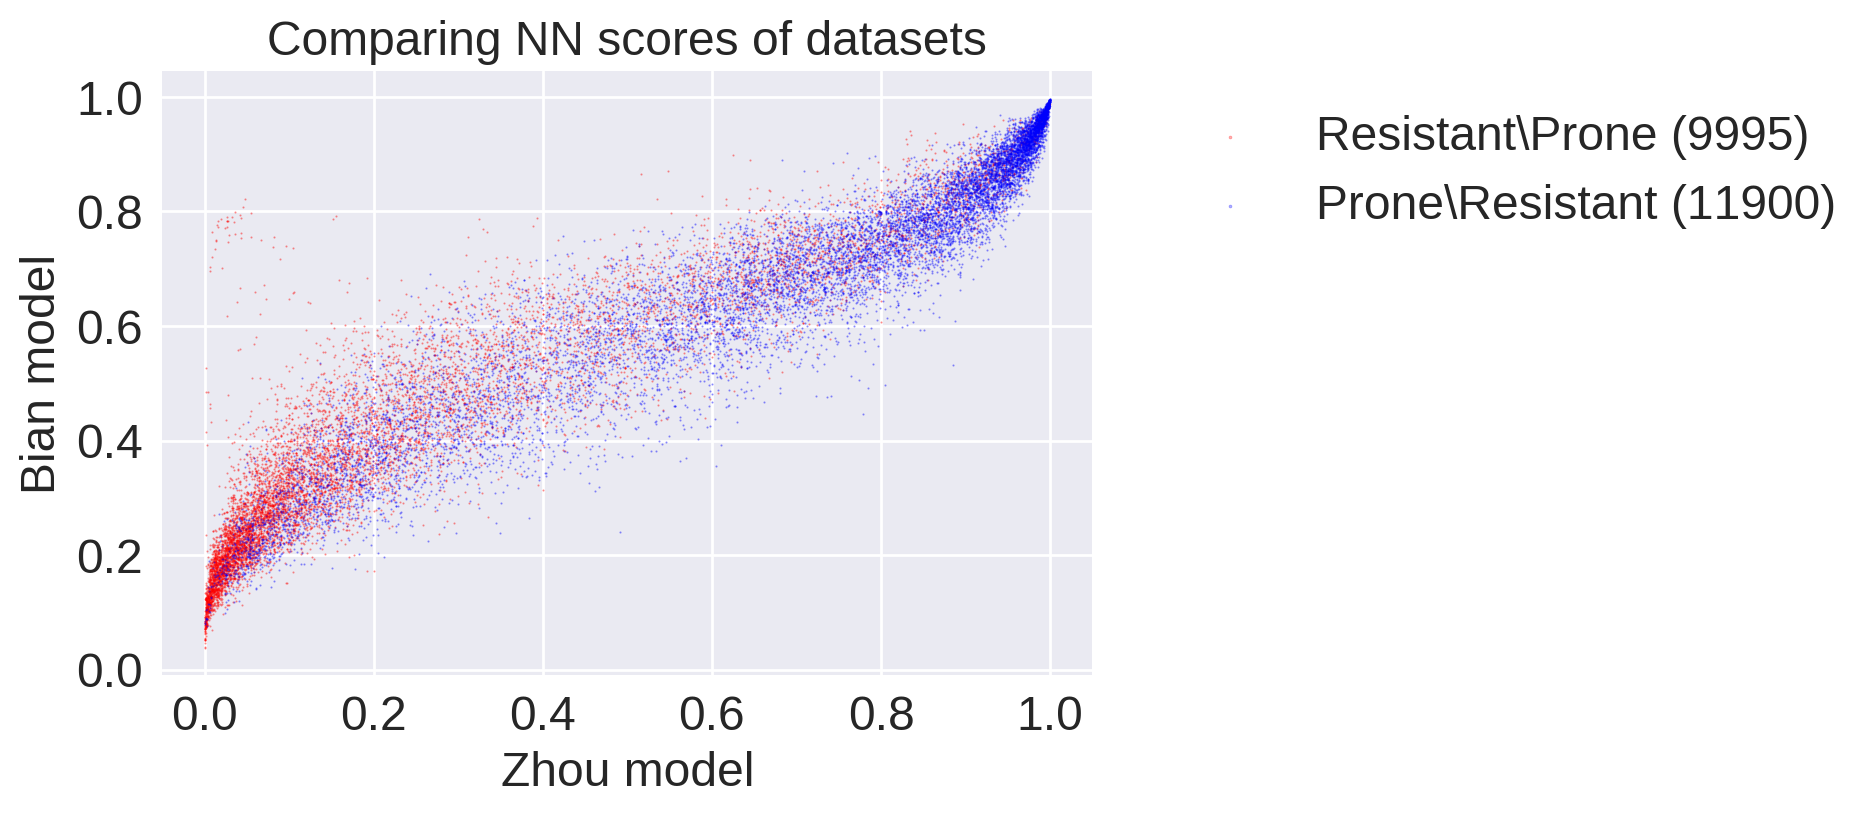

In [ ]:
fig = plt.figure(1, dpi=200)
plt.scatter(zhou_resist_prone, bian_resist_prone, marker=".",label="Resistant\Prone (%s)" %len(bian_resist_prone), c="red",s=1, alpha=0.3)
plt.scatter(zhou_prone_resist, bian_prone_resist, marker=".",label="Prone\Resistant (%s)" %len(bian_prone_resist), c="blue",s=1, alpha=0.3)


plt.xlabel("Zhou model", fontsize="xx-large")
plt.ylabel("Bian model", fontsize= "xx-large")
plt.title("Comparing NN scores of datasets", fontsize="xx-large")
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale =2, fontsize="xx-large")
fig.savefig("2_e_right.pdf", bbox_inches='tight')

# Check ROC curve based on different flanking 

In [ ]:
title = "- Central flank contribution Bian NN"
zhou_models_folder="./models/folds_models/covariance/5-folds"
bian_models_folder="./models/folds_models/sc/5-folds"

bian_data = r"dataset/scwgbs_crc01_dataset/scwgbs1_crc01.pkl"
zhou_all_data = r"dataset/covariance/bulk_prone_0.0153/bulk.pkl"

In [ ]:
title = "- Central flank contribution Zhou NN"
zhou_all_data = r"dataset/covariance/bulk_prone_0.0153/bulk.pkl"
zhou_models_folder="./models/folds_models/covariance/5-folds"

get_nn_performace_against_flank(zhou_all_data, zhou_models_folder, title)


# Check ROC curve based on different sequence changes

In [ ]:
zhou_models_folder="./models/zhou"
bian_models_folder="./models/bian"

bian_data = r"dataset/bian_crc01_train_test.pkl"
zhou_all_data = r"dataset/zhou_train_test.pkl"


In [ ]:
import random 

def get_sequence_without_pattern(frequencies_per_location, test_seq,pattern):
  new_sequences = [] 

  for sequence in test_seq:
    if sequence.count(pattern) > 1:
      index = sequence.find(pattern)
      sequence_as_list = list(sequence)
      while index != -1:
        for i in range(0, len(pattern)):
          new_letter = random.choices(["A","C","G","T"],  weights=frequencies_per_location[index+i])[0]
          sequence_as_list[index+i] = new_letter

        index = sequence.find(pattern, index+i)
      
      new_sequences.append("".join(sequence_as_list))

    else:
      new_sequences.append(sequence) 

  return new_sequences

def get_sequences_by_changing_flank(frequencies_per_location, test_seq, flank):
  start, end = int(len(test_seq[0]) / 2) - 1, int(len(test_seq[0]) / 2)
  new_sequences = [] 

  for sequence in test_seq:
    new_letter_minus =  random.choices(["A","C","G","T"],  weights=frequencies_per_location[start - flank])[0]
    new_letter_plus =  random.choices(["A","C","G","T"],  weights=frequencies_per_location[end + flank])[0]
    sequence = list(sequence)
    sequence[start - flank] = new_letter_minus
    sequence[end + flank] = new_letter_plus
    
    new_sequences.append("".join(sequence))

  return new_sequences

def get_prediction_to_sequences(models, sequences):
  new_sequences = np.array([seq_to_mat(seq) for seq in sequences])
  return predict(models, new_sequences).ravel()


def add_cg(test_seq):
  middle = int(len(test_seq[0]) / 2) - 1
  new_sequences = []
  for sequence in test_seq:
    sequence = list(sequence)
    sequence[middle - 15] = "C"
    sequence[middle - 14] = "G"

    new_sequences.append("".join(sequence))

  return new_sequences

In [ ]:
models_path = zhou_models_folder

_,_,_,_, x_test_seq, y_test, x_train_seq, y_train = load_train_validate_test_data(zhou_all_data, 150, False, kfold=1)

print("Convert to seq info")
test_seq = vecs2dna(x_test_seq)
frequencies_per_location = x_train_seq.mean(axis=0)

# Load the models 
models_paths = glob.glob(os.path.join(models_path, "*"))
models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]

# Get predictions using different models 
y_pred_keras  = predict(models, x_test_seq).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

Convert to seq info


In [ ]:
sequences_changed_1 = get_sequences_by_changing_flank(frequencies_per_location,test_seq, 1)
without_cpg_1_pred = get_prediction_to_sequences(models, sequences_changed_1)
fpr_keras_1, tpr_keras_1, thresholds_keras_1 = roc_curve(y_test, without_cpg_1_pred)
auc_keras_1 = auc(fpr_keras_1, tpr_keras_1)

sequences_changed_12 = get_sequences_by_changing_flank(frequencies_per_location,sequences_changed_1, 2)
without_cpg_12_pred = get_prediction_to_sequences(models, sequences_changed_12)
fpr_keras_12, tpr_keras_12, thresholds_keras_12 = roc_curve(y_test, without_cpg_12_pred)
auc_keras_12 = auc(fpr_keras_12, tpr_keras_12)

sequences_changed_123 = get_sequences_by_changing_flank(frequencies_per_location,sequences_changed_12, 3)
without_cpg_123_pred = get_prediction_to_sequences(models, sequences_changed_123)
fpr_keras_123, tpr_keras_123, thresholds_keras_123 = roc_curve(y_test, without_cpg_123_pred)
auc_keras_123 = auc(fpr_keras_123, tpr_keras_123)

sequences_changed_123_cgca = get_sequence_without_pattern(frequencies_per_location,sequences_changed_123, pattern="CGCA")
without_cpg_123_cgca_pred = get_prediction_to_sequences(models, sequences_changed_123_cgca)
fpr_keras_123_cgca, tpr_keras_123_cgca, thresholds_keras_123_cgca = roc_curve(y_test, without_cpg_123_cgca_pred)
auc_keras_123_cgca = auc(fpr_keras_123_cgca, tpr_keras_123_cgca)

sequences_changed_123_cgca_cg = get_sequence_without_pattern(frequencies_per_location,sequences_changed_123, pattern="CG")
without_cpg_123_cgca_cg_pred = get_prediction_to_sequences(models, sequences_changed_123_cgca_cg)
fpr_keras_123_cgca_cg, tpr_keras_123_cgca_cg, thresholds_keras_123_cgca_cg = roc_curve(y_test, without_cpg_123_cgca_cg_pred)
auc_keras_123_cgca_cg = auc(fpr_keras_123_cgca_cg, tpr_keras_123_cgca_cg)


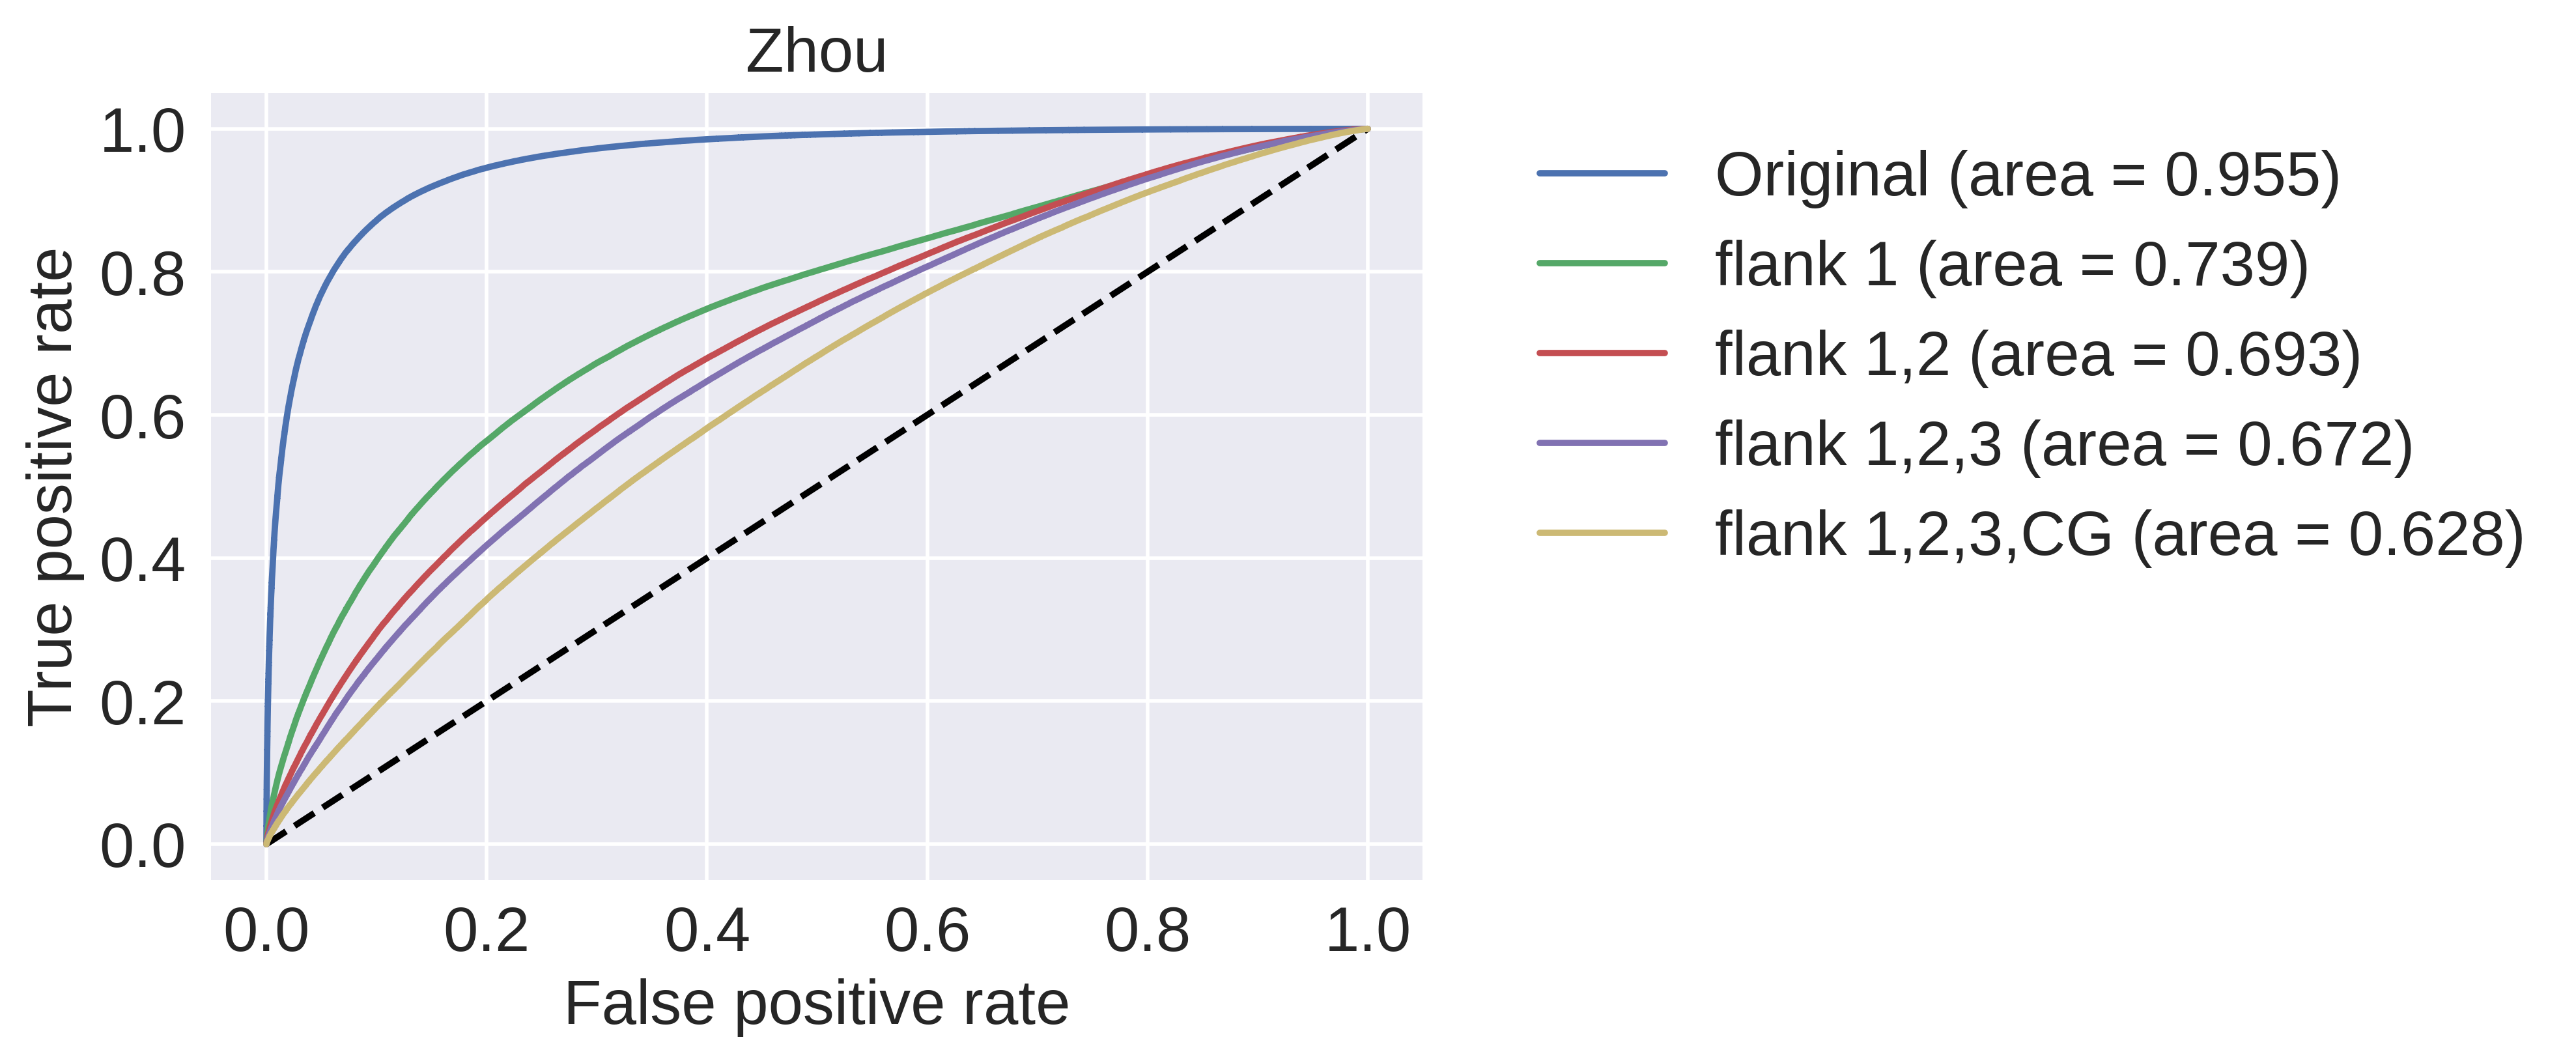

In [ ]:
fig = plt.figure(1, dpi=400)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Original (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras_1, tpr_keras_1, label='flank 1 (area = {:.3f})'.format(auc_keras_1))
plt.plot(fpr_keras_12, tpr_keras_12, label='flank 1,2 (area = {:.3f})'.format(auc_keras_12))
plt.plot(fpr_keras_123, tpr_keras_123, label='flank 1,2,3 (area = {:.3f})'.format(auc_keras_123))
# plt.plot(fpr_keras_123_cgca, tpr_keras_123_cgca, label='flank 1,2,3, cpga (area = {:.3f})'.format(auc_keras_123_cgca))
plt.plot(fpr_keras_123_cgca_cg, tpr_keras_123_cgca_cg, label='flank 1,2,3,CG (area = {:.3f})'.format(auc_keras_123_cgca_cg))

plt.xlabel('False positive rate',fontsize="xx-large")
plt.ylabel('True positive rate',fontsize="xx-large")
plt.title('Zhou',fontsize="xx-large")
plt.legend(fontsize="xx-large",  bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")

plt.show()
fig.savefig("3_f_left.pdf", bbox_inches='tight')

In [ ]:
zhou_models_folder="./models/zhou"
bian_models_folder="./models/bian"

bian_data = r"dataset/bian_crc01_train_test.pkl"
zhou_all_data = r"dataset/zhou_train_test.pkl"


_,_,_,_, x_test_seq, y_test, x_train_seq, y_train = load_train_validate_test_data(bian_data, 150, False, kfold=1)

print("Convert to seq info")
test_seq = vecs2dna(x_test_seq)
frequencies_per_location = x_train_seq.mean(axis=0)

# Load the models 
models_paths = glob.glob(os.path.join(bian_models_folder, "*"))
models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]

# Get predictions using different models 
y_pred_keras  = predict(models, x_test_seq).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

Convert to seq info


In [ ]:
sequences_changed_1 = get_sequences_by_changing_flank(frequencies_per_location,test_seq, 1)
without_cpg_1_pred = get_prediction_to_sequences(models, sequences_changed_1)
fpr_keras_1, tpr_keras_1, thresholds_keras_1 = roc_curve(y_test, without_cpg_1_pred)
auc_keras_1 = auc(fpr_keras_1, tpr_keras_1)

sequences_changed_12 = get_sequences_by_changing_flank(frequencies_per_location,sequences_changed_1, 2)
without_cpg_12_pred = get_prediction_to_sequences(models, sequences_changed_12)
fpr_keras_12, tpr_keras_12, thresholds_keras_12 = roc_curve(y_test, without_cpg_12_pred)
auc_keras_12 = auc(fpr_keras_12, tpr_keras_12)

sequences_changed_123 = get_sequences_by_changing_flank(frequencies_per_location,sequences_changed_12, 3)
without_cpg_123_pred = get_prediction_to_sequences(models, sequences_changed_123)
fpr_keras_123, tpr_keras_123, thresholds_keras_123 = roc_curve(y_test, without_cpg_123_pred)
auc_keras_123 = auc(fpr_keras_123, tpr_keras_123)

# sequences_changed_123_cgca = get_sequence_without_pattern(frequencies_per_location,sequences_changed_123, pattern="CGCA")
# without_cpg_123_cgca_pred = get_prediction_to_sequences(models, sequences_changed_123_cgca)
# fpr_keras_123_cgca, tpr_keras_123_cgca, thresholds_keras_123_cgca = roc_curve(y_test, without_cpg_123_cgca_pred)
# auc_keras_123_cgca = auc(fpr_keras_123_cgca, tpr_keras_123_cgca)

sequences_changed_123_cgca_cg = get_sequence_without_pattern(frequencies_per_location,sequences_changed_123, pattern="CG")
without_cpg_123_cgca_cg_pred = get_prediction_to_sequences(models, sequences_changed_123_cgca_cg)
fpr_keras_123_cgca_cg, tpr_keras_123_cgca_cg, thresholds_keras_123_cgca_cg = roc_curve(y_test, without_cpg_123_cgca_cg_pred)
auc_keras_123_cgca_cg = auc(fpr_keras_123_cgca_cg, tpr_keras_123_cgca_cg)



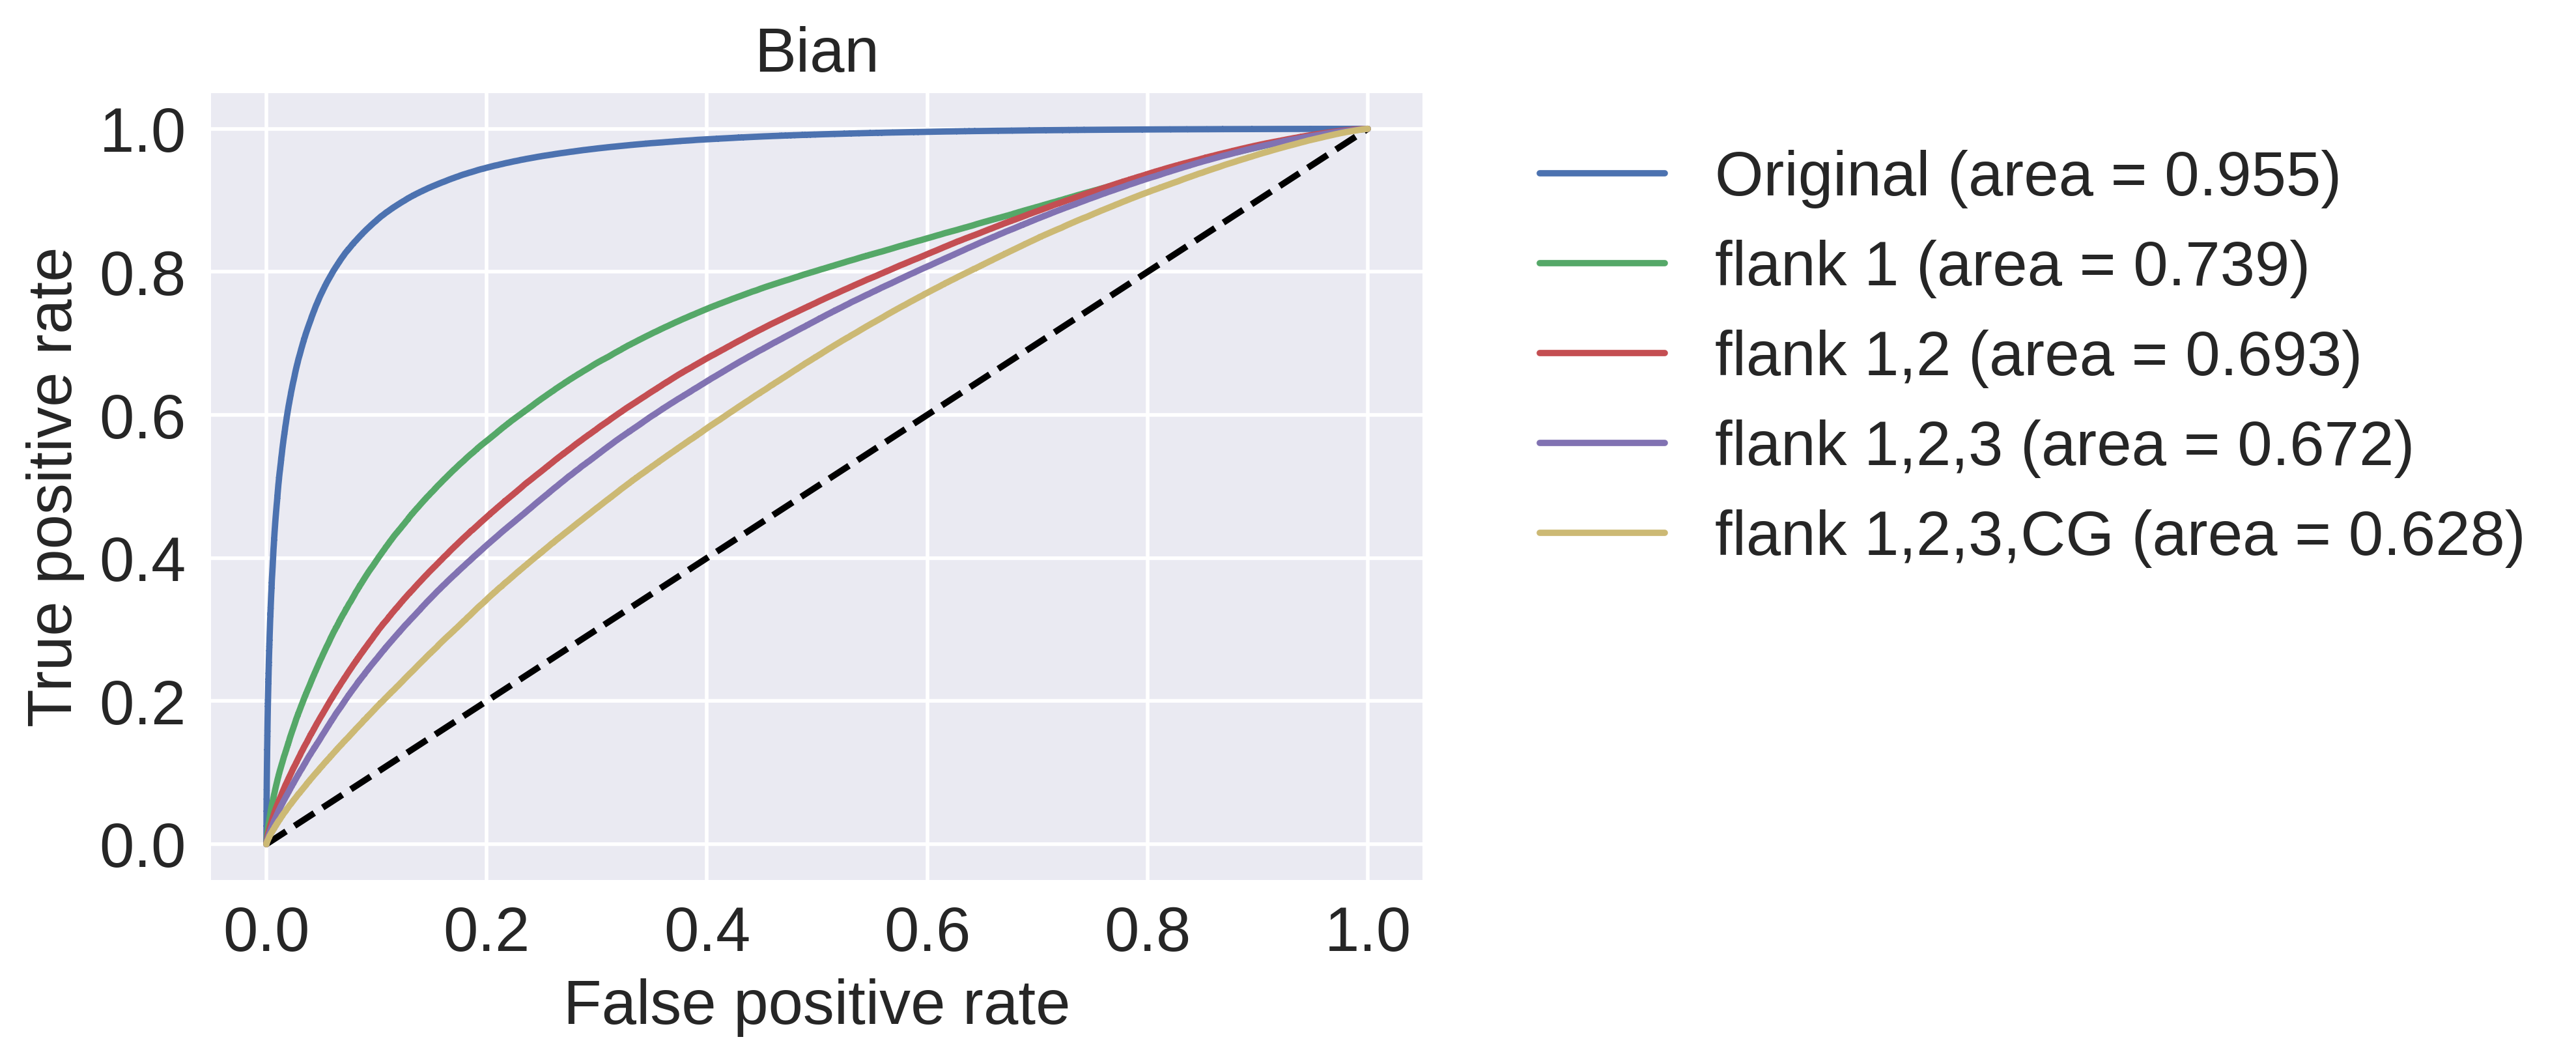

In [ ]:
fig = plt.figure(1, dpi=400)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Original (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras_1, tpr_keras_1, label='flank 1 (area = {:.3f})'.format(auc_keras_1))
plt.plot(fpr_keras_12, tpr_keras_12, label='flank 1,2 (area = {:.3f})'.format(auc_keras_12))
plt.plot(fpr_keras_123, tpr_keras_123, label='flank 1,2,3 (area = {:.3f})'.format(auc_keras_123))
# plt.plot(fpr_keras_123_cgca, tpr_keras_123_cgca, label='flank 1,2,3, cpga (area = {:.3f})'.format(auc_keras_123_cgca))
plt.plot(fpr_keras_123_cgca_cg, tpr_keras_123_cgca_cg, label='flank 1,2,3,CG (area = {:.3f})'.format(auc_keras_123_cgca_cg))

plt.xlabel('False positive rate',fontsize="xx-large")
plt.ylabel('True positive rate',fontsize="xx-large")
plt.title('Bian',fontsize="xx-large")
plt.legend(fontsize="xx-large",  bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")

# plt.show()
fig.savefig("3_f_right.pdf", bbox_inches='tight')

# Correlation of all CpGs 

In [ ]:
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.stats import pearsonr


zhou_all_cpgs = "./dataset/zhou_pmds_with_pred.pkl"
bian_all_cpgs = "./dataset/bian_crc01_pmds_with_pred.pkl"

In [ ]:
data = pd.read_pickle(zhou_all_cpgs)
data["ccpg"] = data["sequence"].str.count("CG")
data_density_up_to_3 = data[data["ccpg"] < 4]
data_density_from_3 = data[data["ccpg"] > 3]

<Figure size 2400x1600 with 0 Axes>

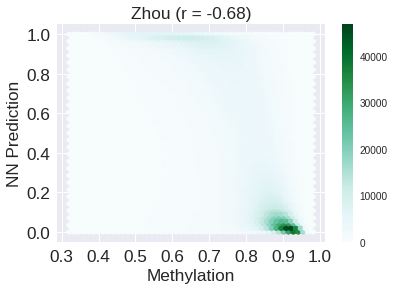

In [ ]:
fig = plt.figure(dpi=400)

corr, _ = pearsonr(data_density_up_to_3["meth"], data_density_up_to_3["pred"])
data_density_up_to_3.plot.hexbin( x="meth", y="pred", gridsize=50, sharex=False)


plt.title('Zhou (r = %.2f)' %corr, fontsize="xx-large")
plt.ylabel('NN Prediction', fontsize="xx-large")
plt.xlabel('Methylation', fontsize="xx-large")
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")
fig.savefig("sup2_e_left.pdf", bbox_inches='tight')

<Figure size 2400x1600 with 0 Axes>

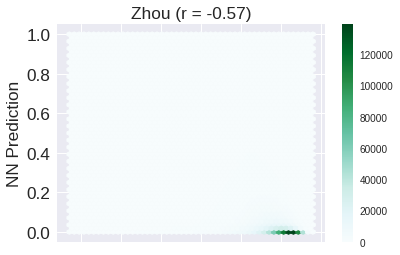

In [ ]:
fig = plt.figure(1, dpi=400)

corr, _ = pearsonr(data_density_from_3["meth"], data_density_from_3["pred"])
data_density_from_3.plot.hexbin( x="meth", y="pred", gridsize=50)


plt.title('Zhou (r = %.2f)' %corr, fontsize="xx-large")
plt.ylabel('NN Prediction', fontsize="xx-large")
plt.xlabel('Methylation', fontsize="xx-large")
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")
fig.savefig("sup2_h_left.pdf", bbox_inches='tight')

In [ ]:
data = pd.read_pickle(bian_all_cpgs)
data["ccpg"] = data["sequence"].str.count("CG")
data_density_up_to_3 = data[data["ccpg"] < 4]
data_density_from_3 =data[data["ccpg"] >3]


<Figure size 2400x1600 with 0 Axes>

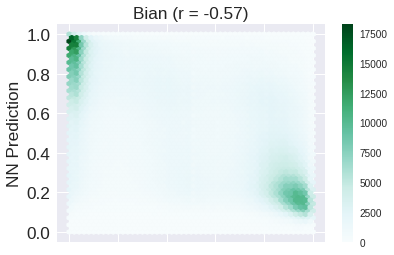

In [ ]:
fig = plt.figure(1, dpi=400)

corr, _ = pearsonr(data_density_up_to_3["meth"], data_density_up_to_3["pred"])
data_density_up_to_3.plot.hexbin( x="meth", y="pred", gridsize=50)


plt.title('Bian (r = %.2f)' %corr, fontsize="xx-large")
plt.ylabel('NN Prediction', fontsize="xx-large")
plt.xlabel('Methylation', fontsize="xx-large")
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")
fig.savefig("sup2_f_right.pdf", bbox_inches='tight')

<Figure size 2400x1600 with 0 Axes>

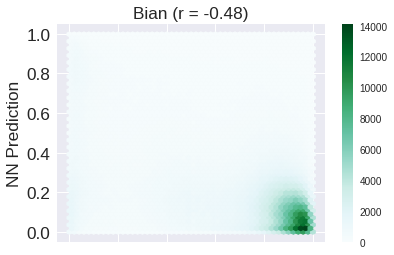

In [ ]:
plt.figure(1, dpi=400)
corr, _ = pearsonr(data_density_from_3["meth"], data_density_from_3["pred"])
data_density_from_3.plot.hexbin( x="meth", y="pred", gridsize=50)


plt.title('Bian (r = %.2f)' %corr, fontsize="xx-large")
plt.ylabel('NN Prediction', fontsize="xx-large")
plt.xlabel('Methylation', fontsize="xx-large")
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")
fig.savefig("sup2_h_right.pdf", bbox_inches='tight')